# SHAP analyses

In [1]:
import numpy as np
import pandas as pd
import pickle
import shap

import sklearn as sk
import sklearn.ensemble
import sklearn.svm
import sklearn.model_selection

import warnings

In [2]:
# read training and test dataset
[X_trainvalid, X_test, y_trainvalid, y_test] = pickle.load(open('./dataset/raw_data.pickle', 'rb'))

In [3]:
# read full dataset
store = pd.HDFStore('./dataset/data_train.h5')
df_dataset = store['df_all']
store.close()

In [4]:
X_trainvalid_raw=df_dataset.loc[X_trainvalid.index]
X_test_raw=df_dataset.loc[X_test.index]

# train model

In [5]:
hyperparameters = {'C': 1000.0, 'epsilon': 0.046415888336127795}
model = sklearn.svm.SVR(**hyperparameters)

In [6]:
model.fit(X_trainvalid,y_trainvalid)

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.046415888336127795,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

# SHAP for all test data

In [7]:
# calculate shap values (this may take a while)
shap.initjs()
med = X_trainvalid.median().values.reshape((1,X_trainvalid.shape[1]))
explainer = shap.KernelExplainer(lambda x: model.predict(x),med)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(X_trainvalid)
expected_value = explainer.expected_value

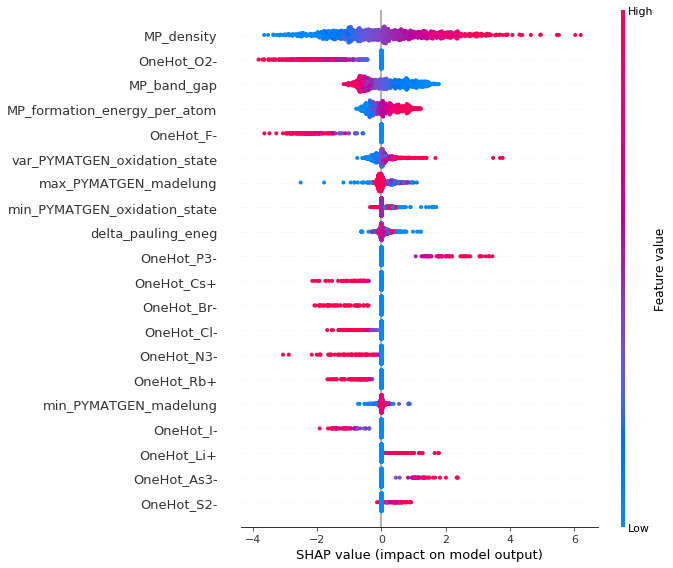

In [8]:
# Fig 2
shap.summary_plot(shap_values, X_trainvalid, show=False)

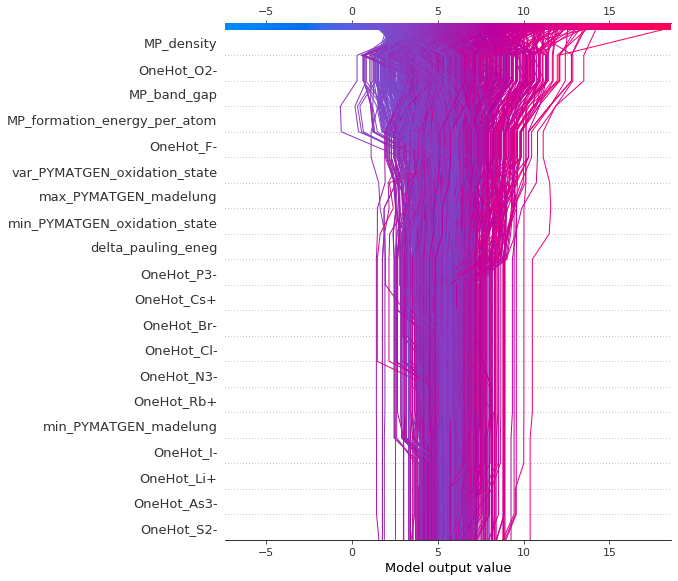

In [9]:
# Clearly show importance of density
shap.decision_plot(expected_value, shap_values, X_trainvalid.columns.values)
shap.force_plot(explainer.expected_value, shap_values, X_trainvalid_raw[X_trainvalid.columns.values])

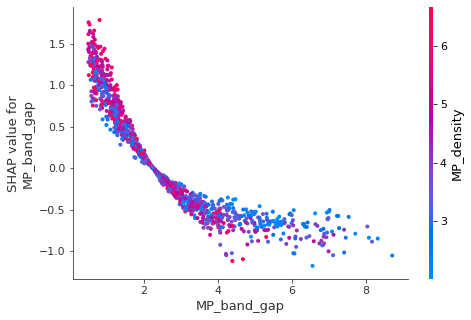

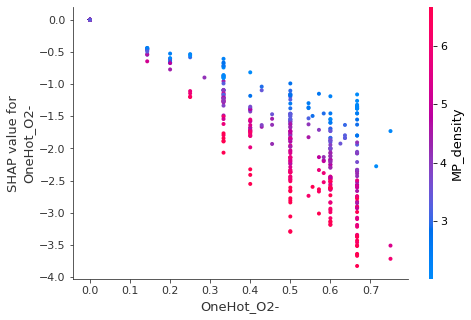

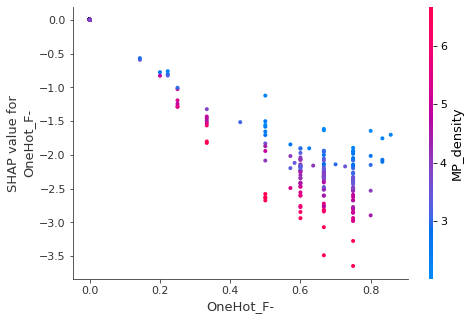

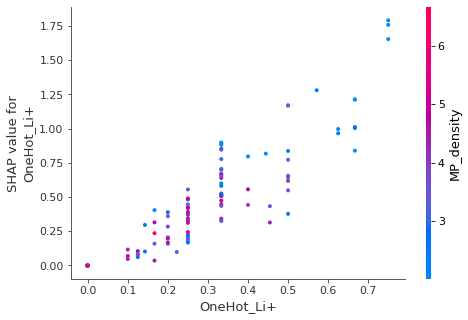

In [10]:
# args={'shap_values':shap_values, 'features':X_trainvalid_raw[X_trainvalid.columns.values], 'feature_names':None, 
#       'display_features':None, 'interaction_index':'MP_density', 'color':'#1E88E5', 'axis_color':'#333333',
#       'cmap':None, 'dot_size':16, 'x_jitter':0, 'alpha':1, 'title':None, 'xmin':None, 'xmax':None, 'ax':None, 'show':True}

args={'shap_values':shap_values, 'features':X_trainvalid_raw[X_trainvalid.columns.values],'interaction_index':'MP_density'}

# Fig 3(a)
shap.dependence_plot('MP_band_gap', **args)
# Fig 3(b)
shap.dependence_plot('OneHot_O2-', **args)
# Fig 3(c)
shap.dependence_plot('OneHot_F-', **args)                                    
# Fig 3(d)
shap.dependence_plot('OneHot_Li+', **args)

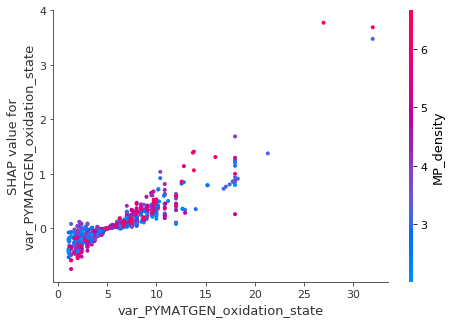

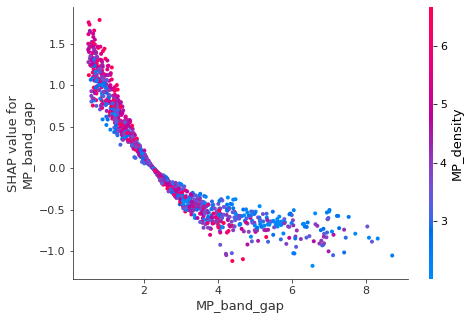

In [11]:
# Fig S8(a)
shap.dependence_plot('var_PYMATGEN_oxidation_state', **args)
# Fig S8(b)
shap.dependence_plot('MP_band_gap', **args)

# error assessing

In [12]:
# materials with large error (Table III)
list_large_error=[
    'mp-9244', 'mp-2371', 'mp-555874', 'mp-19765', 'mp-773137', 
    'mp-10969', 'mp-541911', 'mp-12954', 'mp-983565', 'mp-23353']
# calculate SHAP values for materials with large error
X_test_large_error = \
    X_test.iloc[pd.Index(X_test_raw['MP_material_id']).get_indexer(list_large_error)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values_large_error = explainer.shap_values(X_test_large_error)

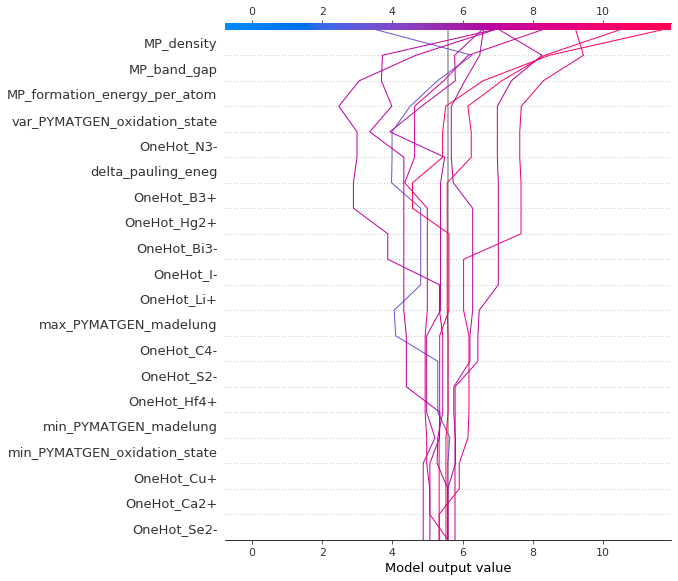

In [13]:
# density is dominant in these materials, too
shap.decision_plot(expected_value, shap_values_large_error, X_test_large_error.columns.values)

LiBC


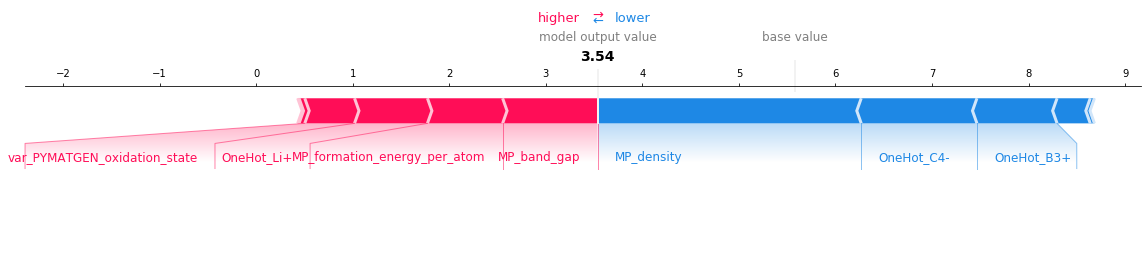

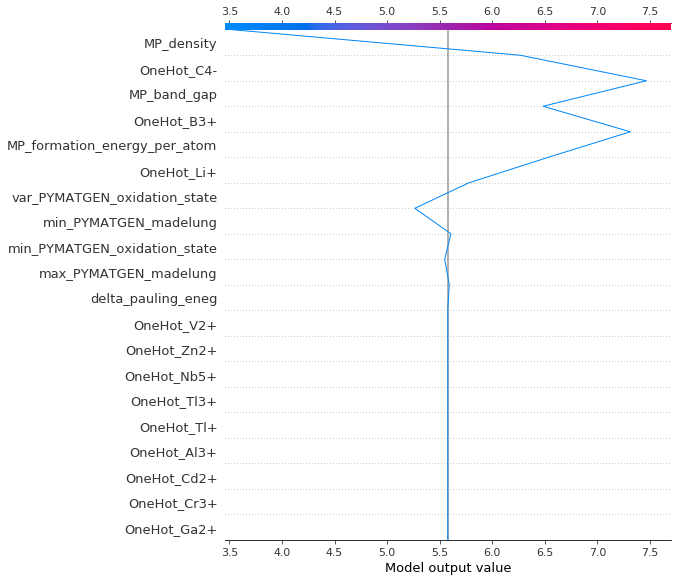

Ga2Te5


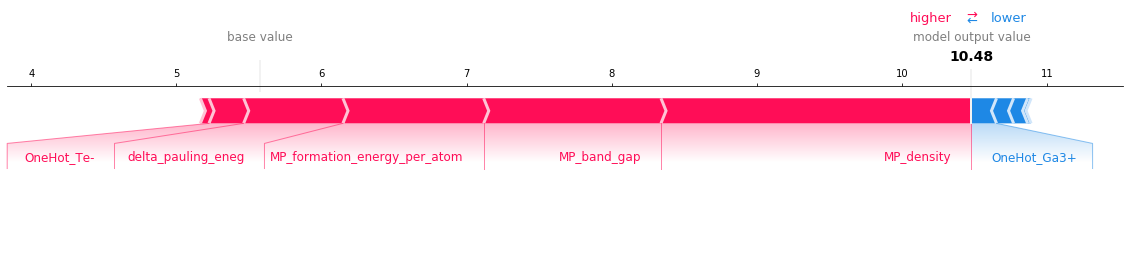

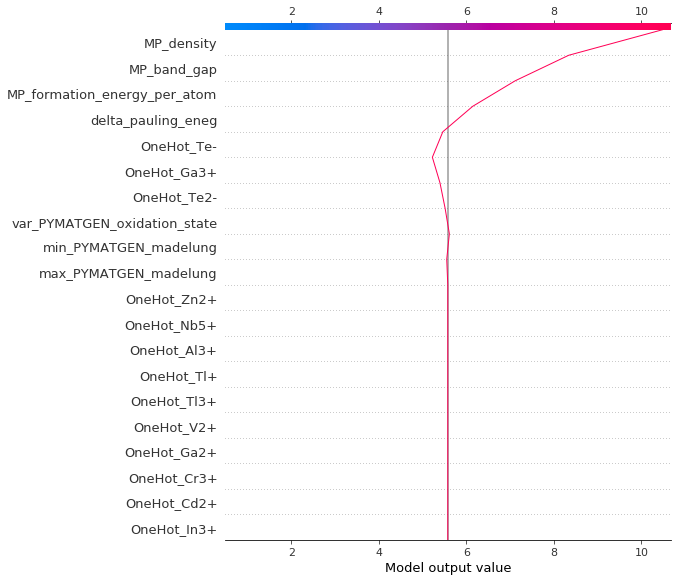

LiAsS2


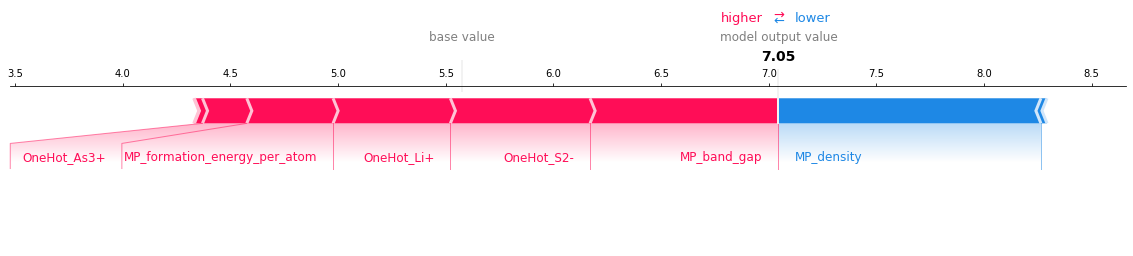

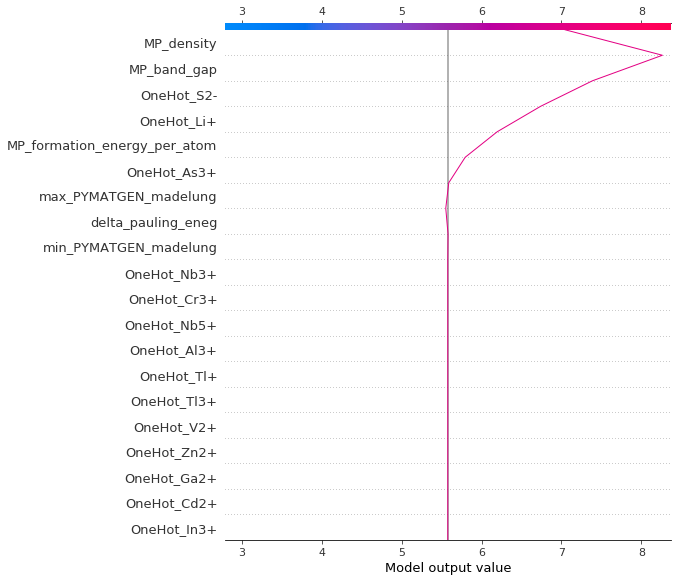

In2HgTe4


In [ ]:
# decision plot for all 10 materials (including Figs 4(a) and (b))
for mpid,shap_value in zip(list_large_error,shap_values_large_error):
    print(X_test_raw.loc[X_test_raw.MP_material_id == mpid]['MP_pretty_formula'].values[0])
    shap.force_plot(expected_value, shap_value, X_test_large_error.columns, matplotlib=True)
    shap.decision_plot(expected_value, shap_value, X_test_large_error.columns)